# Open Data Spatial Visualization

In [1]:
import pandas as pd
import numpy as np
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Fetch Data

In [2]:
CRASH_DATA_URL = "https://data.cityofchicago.org/resource/85ca-t3if.json"

In [3]:
query = """
SELECT
    date_extract_y(crash_date) AS year,
    date_extract_m(crash_date) AS month,
    date_extract_dow(crash_date) AS dow,
    date_extract_hh(crash_date) AS hour,
    beat_of_occurrence AS beat,
    street_direction || ' ' || street_name AS street,
    CASE(hit_and_run_i == 'Y', 1, TRUE, 0) AS hit_and_run,
    CASE(injuries_total > 0, 1, TRUE, 0) AS had_injuries,
    longitude,
    latitude
WHERE
    crash_date >= '2019-01-01'
    AND crash_date < '2019-02-01'
    AND crash_date <= date_police_notified
    AND crash_date IS NOT NULL
    AND beat_of_occurrence IS NOT NULL
    AND street_name IS NOT NULL
    AND injuries_total IS NOT NULL
    AND longitude < 0
    AND latitude > 0
LIMIT 10000
"""

In [4]:
print("Querying dataset...")
r = requests.get(CRASH_DATA_URL, params={"$query": query})
rows = r.json()
df = pd.DataFrame(rows)
print("Fetched {} records.".format(len(df)))
print("Missing values in {} records.".format(len(df) - len(df.dropna())))

Querying dataset...
Fetched 8947 records.
Missing values in 0 records.


In [5]:
df["hit_and_run"] = df["hit_and_run"].astype(int)
df["had_injuries"] = df["had_injuries"].astype(int)
df["hour"] = df["hour"].astype(int)
df["dow"] = df["dow"].astype(int)
df["month"] = df["month"].astype(int)
df["year"] = df["year"].astype(int)
df["latitude"] = df["latitude"].astype(float)
df["longitude"] = df["longitude"].astype(float)
df.head()

,beat,dow,had_injuries,hit_and_run,hour,latitude,longitude,month,street,year
0,235,2,0,1,0,41.793502,-87.586407,1,E 56TH ST,2019
1,1123,2,0,1,0,41.883685,-87.710043,1,W MAYPOLE AVE,2019
2,1922,2,0,1,0,41.946856,-87.670809,1,W ADDISON ST,2019
3,122,2,0,0,0,41.882058,-87.633478,1,W MADISON ST,2019
4,1624,2,0,1,0,41.954529,-87.784311,1,N MOBILE AVE,2019


In [6]:
# EVENT = "hit_and_run"
# EVENT_NAME = "Hit and Runs"
EVENT = "had_injuries"
EVENT_NAME = "Crashes with Injury"
print("Sample contains {} {} events.".format(df[EVENT].sum(), EVENT))

Sample contains 1054 had_injuries events.


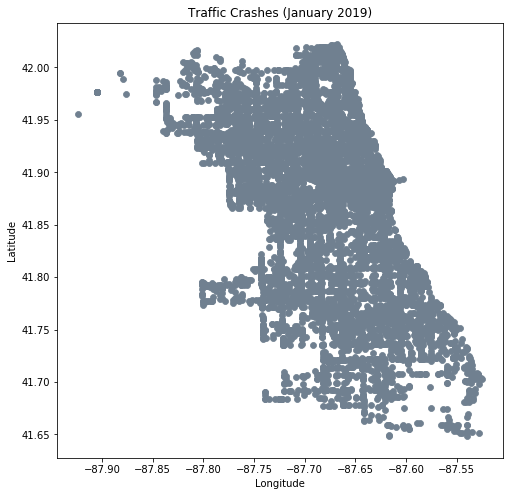

In [7]:
sns.scatterplot(
    x="longitude", y="latitude",
    color="slategray", edgecolor=None,
    data=df
)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Crashes (January 2019)")
plt.show()

## Police Beats

In [8]:
N_BEATS = 279
print("Sample contains {}/{} police beats.".format(len(df["beat"].unique()), N_BEATS))

Sample contains 271/279 police beats.


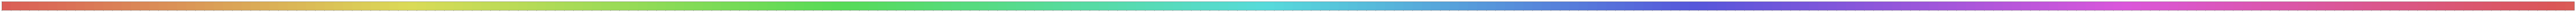

In [9]:
beat_pal = sns.color_palette("hls", N_BEATS)
sns.palplot(beat_pal)

In [10]:
pal = sns.color_palette("hls", 5)
beats = list(df["beat"].unique())
colors = list(pal)
beat_cmp = {}
for i, beat in enumerate(beats):
    beat_cmp[beat] = colors[i % len(colors)]
# Set the color for IIT's police beat
beat_cmp["211"] = (0, 0, 0)

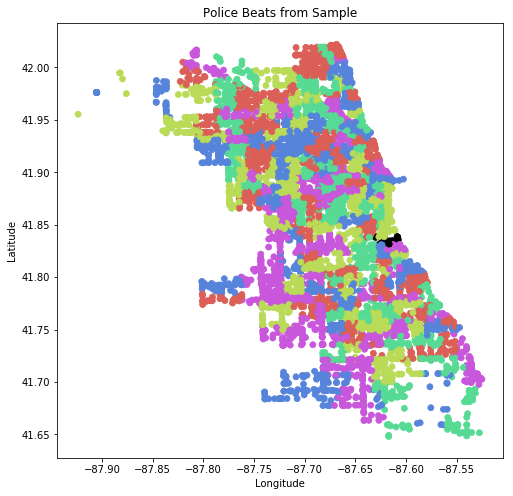

In [11]:
sns.scatterplot(
    x="longitude", y="latitude",
    hue="beat", palette=beat_cmp,
    legend=False, edgecolor=None,
    data=df
)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Police Beats from Sample")
plt.show()

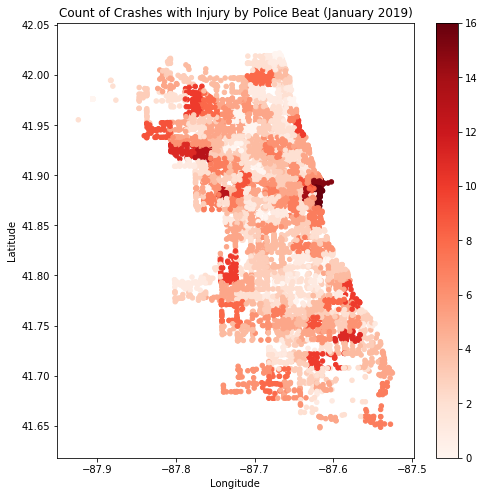

In [12]:
event_count = df.groupby("beat")[EVENT].sum()

fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
hue = df["beat"].apply(lambda beat: event_count[beat])
points = ax.scatter(df["longitude"], df["latitude"], c=hue, s=20, cmap="Reds")

fig.colorbar(points)
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Count of {} by Police Beat (January 2019)".format(EVENT_NAME))
plt.show()

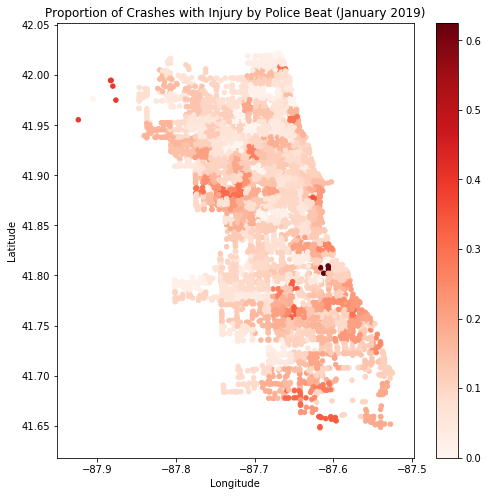

In [13]:
event_proportion = df.groupby("beat")[EVENT].mean()

fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
hue = df["beat"].apply(lambda beat: event_proportion[beat])
points = ax.scatter(df["longitude"], df["latitude"], c=hue, s=20, cmap="Reds")

fig.colorbar(points)
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proportion of {} by Police Beat (January 2019)".format(EVENT_NAME))
plt.show()

## Street Names

In [14]:
print("Sample contains {} unique streets.".format(len(df["street"].unique())))

Sample contains 1024 unique streets.


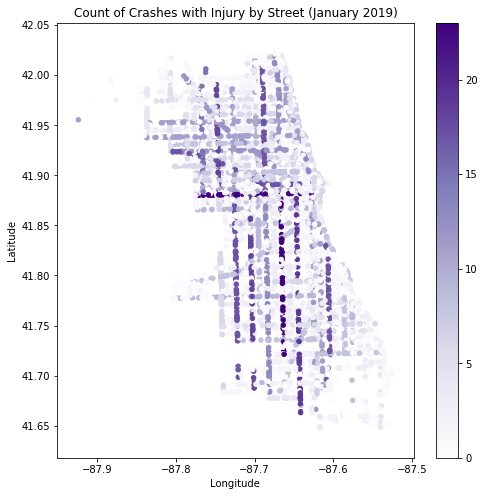

In [15]:
event_count = df.groupby("street")[EVENT].sum()

fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
hue = df["street"].apply(lambda street: event_count[street])
points = ax.scatter(df["longitude"], df["latitude"], c=hue, s=20, cmap="Purples")

fig.colorbar(points)
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Count of {} by Street (January 2019)".format(EVENT_NAME))
plt.show()

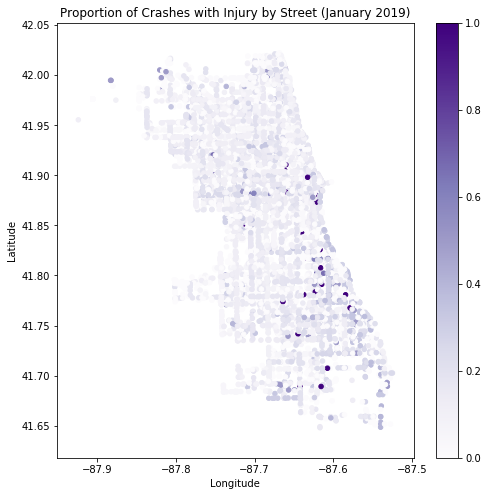

In [16]:
event_proportion = df.groupby("street")[EVENT].mean()

fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
hue = df["street"].apply(lambda street: event_proportion[street])
points = ax.scatter(df["longitude"], df["latitude"], c=hue, s=20, cmap="Purples")

fig.colorbar(points)
fig.set_size_inches(8, 8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proportion of {} by Street (January 2019)".format(EVENT_NAME))
plt.show()

## Police Beats Over Time

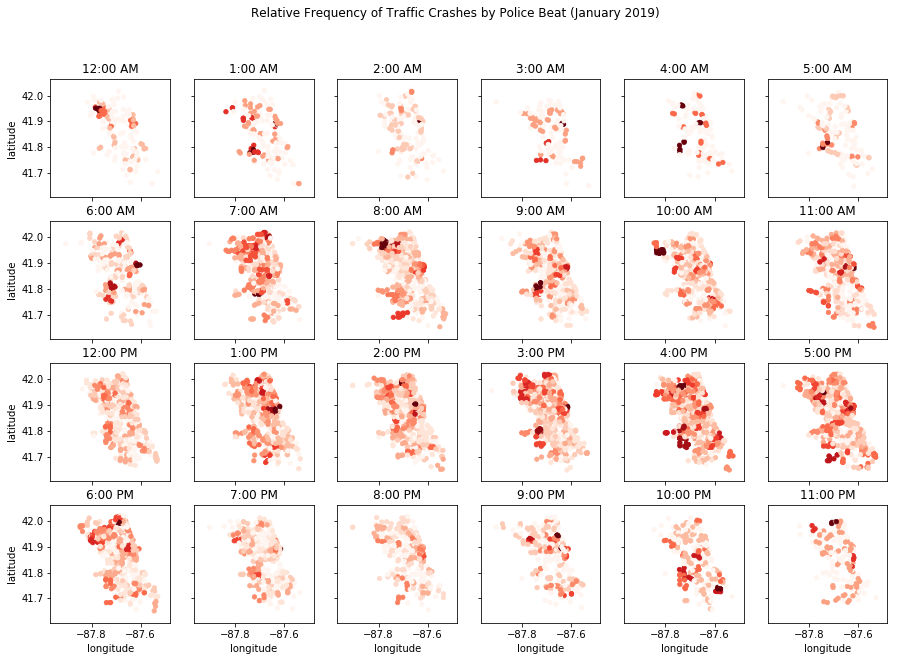

In [17]:
fig, axes = plt.subplots(4, 6, sharex=True, sharey=True)

for h, ax in enumerate(axes.flatten()):
    df_hour = df.query("hour == {}".format(h))
    hourly_crash_count = df_hour.groupby("beat")["beat"].count()
    beat_hue = df_hour["beat"].apply(lambda beat: hourly_crash_count[beat] / len(df))
    sns.scatterplot(
        x="longitude", y="latitude",
        hue=beat_hue, palette="Reds",
        s=20, edgecolor=None,
        data=df_hour, ax=ax
    )
    ax.legend().set_visible(False)
    ax.set_title("{}:00 {}".format(12 if h % 12 == 0 else h % 12, "AM" if h < 12 else "PM"))
fig.set_size_inches((15, 10))
fig.suptitle("Relative Frequency of Traffic Crashes by Police Beat (January 2019)")
plt.show()

## Fraction vs Rate by Hour

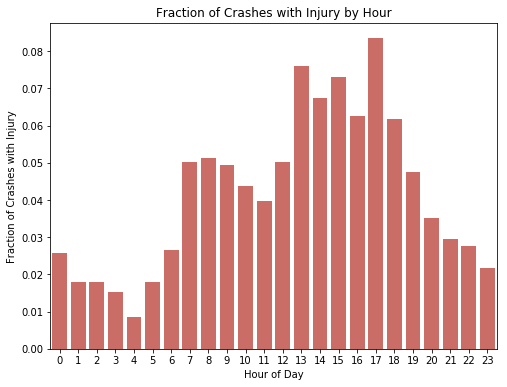

In [18]:
hour_rate = df.groupby(by="hour")[EVENT].sum() / df[EVENT].sum()
sns.barplot(hour_rate.index,hour_rate.values, color=pal[0])
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of {}".format(EVENT_NAME))
plt.title("Fraction of {} by Hour".format(EVENT_NAME))
plt.gcf().set_size_inches(8, 6)
plt.show()

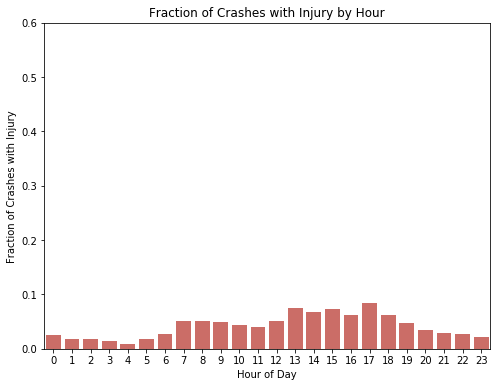

In [19]:
hour_rate = df.groupby(by="hour")[EVENT].sum() / df[EVENT].sum()
sns.barplot(hour_rate.index,hour_rate.values, color=pal[0])
plt.ylim(0, 0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of {}".format(EVENT_NAME))
plt.title("Fraction of {} by Hour".format(EVENT_NAME))
plt.gcf().set_size_inches(8, 6)
plt.show()

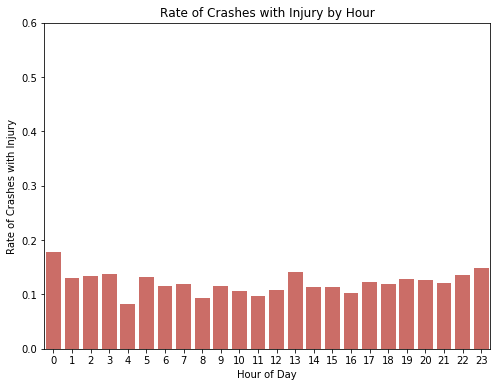

In [20]:
hour_rate = df.groupby(by="hour")[EVENT].mean()
sns.barplot(hour_rate.index,hour_rate.values, color=pal[0])
plt.ylim(0, 0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Rate of {}".format(EVENT_NAME))
plt.title("Rate of {} by Hour".format(EVENT_NAME))
plt.gcf().set_size_inches(8, 6)
plt.show()